In [1]:
# Data packages
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from model.encoders import CustomExcelFormer

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

from model.utils import get_device, generate_predictions

from data_processing.pipeline import encoding_pipeline, get_generic_name

from model.rnn import GRUDecoder
from model.autoencoder import SimpleAutoEncoder

from model.dataset import PretrainingDataset
from model.dataset import FinetuningDataset
from IPython.display import clear_output


In [2]:
device = get_device()
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
targets_df = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')
importance = pd.read_csv('features_importance_all.csv')

Using MPS (Metal Performance Shaders) device


# What is the effect of increasing the number of questions?

## Pretraining
I pretrain on all the data. Currently, I only use the Attn-based autoencoder as it seems to train the fastest.

## Finetuning
We perform 5-fold cross validation for the FT.

### Pretraining

In [9]:
# set parameters for the PT
BATCH_SIZE = 16
HIDDEN_SIZE = 96
ENCODING_SIZE = 96
NUM_HEADS = 3
NUM_LAYERS = 3
RNN_NUM_LAYERS = 2

NUM_EPOCHS = 15
LEARNING_RATE = 1e-3

n_questions = [50, 100, 150, 500, 1000, 5000, 10000]#, 1000, 2000, 4000, 8000, 16000, 27000]
MODEL_PATH = model_name = f"saturation_test_ENC_nquestions"

In [10]:
def prepare_data(n_cols):
    custom_pairs = importance.feature.map(lambda x: get_generic_name(x)).unique()[:n_cols]
    n_cols = len(set(custom_pairs))
    #n_cols_list = n_cols
    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs, importance=importance, use_codebook=True)
    pretrain_dataset = PretrainingDataset(sequences)

    seq_len = pretrain_dataset.get_seq_len()
    vocab_size = pretrain_dataset.get_vocab_size()

    

    rnn_data = {
        person_id: (
            torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
            torch.tensor([wave_response for _, wave_response in wave_responses.items()]).to(device)
            )
            for person_id, wave_responses in sequences.items()
    }

    targets = targets_df[targets_df.new_child.notna()]
    train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)
    train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
    test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

    # prepare the data for finetuning
    train_dataset = FinetuningDataset(train_data, targets = targets)
    test_dataset = FinetuningDataset(test_data, targets = targets)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE)

    return {"train": train_dataloader,
            "test": test_dataloader,
            "seq_len": seq_len,
            "vocab_size": vocab_size}

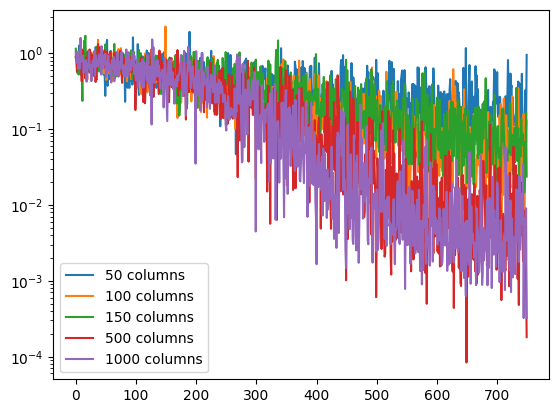

/Users/carlomarx/Documents/GitHub/fertility-prediction-challenge/data_processing/pipeline.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


Embedding Layer with Question Embdeddings
Embedding Layer with the Dropout


Epochs 0: 0it [00:00, ?it/s]

: 

In [11]:
all_train_loss = []   # for plotting
n_cols_list = []
metric_per_run = {}
for n_quest in n_questions:

    model_name = MODEL_PATH + '-' + str(n_quest)
    ### DATA
    data_obj = prepare_data(n_quest)
    train_dataloader = data_obj["train"]
    test_dataloader = data_obj["test"]
    SEQ_LEN = data_obj["seq_len"]
    VOCAB_SIZE = data_obj["vocab_size"]
    
    encoder = CustomExcelFormer(vocab_size=VOCAB_SIZE, 
                            hidden_size=HIDDEN_SIZE, 
                            out_size=ENCODING_SIZE,
                            n_years=14,
                            num_heads=NUM_HEADS,
                            num_layers=NUM_LAYERS, 
                            sequence_len=SEQ_LEN, 
                            aium_dropout=0.3,
                            diam_dropout=0.1,
                            residual_dropout=0.1,
                            embedding_dropout=0.1,
                            mixup=None,
                            beta=0.2).to(device)
    
    decoder = GRUDecoder(input_size=ENCODING_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, max_seq_len=14,
                            dropout=0.2, bidirectional=False, with_attention = True).to(device)

    # Define loss function and optimizer for RNN
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1/0.5]).to(device))
    optimizer = torch.optim.RAdam(list(decoder.parameters()) + list(encoder.parameters()), lr=LEARNING_RATE,
                                     weight_decay=1e-2, decoupled_weight_decay=True)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = NUM_EPOCHS,
                                                        eta_min = 1e-5, last_epoch = -1)

    
    full_loss = []
    loss_per_epoch = []
    for epoch in range(NUM_EPOCHS):
        # print(epoch)
        loss_per_step = []
        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
        for i, batch in loop_object :        
            optimizer.zero_grad() 
            inputs, labels = batch
            labels = labels.to(torch.float).to(device)

            input_year, input_seq = inputs
            bs, ss = labels.size(0), 14
            input_year = input_year.reshape(-1).to(device)
            input_seq = input_seq.reshape(bs * ss, -1).to(device)

            encodings, _ = encoder(input_year, input_seq)
            encodings = encodings.view(bs,ss, -1)
            mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()

            # Forward pass
            outputs = decoder(encodings, mask=mask).flatten()
            yhat = F.sigmoid(outputs)

            loss = loss_fn(outputs, labels)  
            loss_per_step.append(loss.detach().cpu().numpy())
            loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_per_step[-100:]))
            full_loss.append(loss.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
        # On epoch end
        loss_per_epoch.append(np.mean(loss_per_step))
        scheduler.step()

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss_per_epoch[-1]:.4f}")
    metric_per_run[n_quest] = full_loss
    clear_output()
    for k,v in metric_per_run.items():
        plt.plot(v, label="%s columns" %k)
        plt.yscale("log")
    plt.legend()
    plt.show()
    print('')